## 행렬 분해 적합도 테스트

### 행렬 분해 개요
- 행렬 분해는 원본 행렬 A를 여러가지 특성으로 행렬들을 쪼개는 것을 말한다.
- 행렬 분해의 방법 중 SVD 는 (m * n) 의 원본 행렬을 (m * m:직교행렬:U) * (m * n:대각행렬:sigma) * (n * n:직교행렬:V) 의 형식으로 행렬을 분해해준다.
- 이들의 내적은 원본 행렬 A가 되며, 여기서 sigma 대각행렬은 원본 행렬 A의 정보량(=특징)을 담고 있는 행렬이 된다.
- 추천 서비스와 같은 서비스에서, 행렬분해는 원본 행렬 A를 SVD 기법으로 U, Sigma, V 로 분해 시키고, Sigma 행렬의 크기를 축소시켜서 기존의 원본 행렬 A보다 정보량이 적어진 행렬 A^T를 출력해낸다. (Truncated SVD)
    - 해당 행렬의 특징을 잘 나타내주는 데이터들은 원본과 유사하게 데이터를 유지하게 될 것이며, 그렇지 않은 데이터들은 그 특징이 사라지다시피 할 것 이다. 이를 노이즈를 제거했다. 라는 의미로 나타낸다.
    - 더 나아가 노이즈를 제거한, 즉 행렬분해를 통해 정보량을 줄인 행렬을 분석하는 기법은 LSA, Latent Semantic Analysis, 잠재 의미 분석 이라고 한다.
---

### 테스팅 방법
- 우리는 여기까지, improved cosine similarity 가 거리의 면에서, 방향성의 면에서, 상관계수의 면에서 다른 유사도 알고리즘이 가지지 못했던, 거리와 방향을 고려할 수 있다는 것에 대해서 측정을 해봤었다.
- 그러면, 행렬분해를 진행했고, 잠재의미분석을 진행시키기 위해 해당 알고리즘을 사용하면 어떤 변화가 일어날 지 테스트 해보겠다.
0. 원본행렬의 크기는 (100,128) 로 진행.
1. 행렬분해의 크기에 따라 각 벡터의 모든 벡터간의 improved cosine similarity 지수가 가장 높은 (전체적인 데이터와 가장 유사도가 높은) 벡터를 추천했을 때, 크기에 따라 추천하는 데이터가 달라지는가?
2. (1번의 내용이 맞았을 때), 축소 시킨 데이터에서 추천된 벡터가 euclidean distance, cosine similarity, pearson correlation coeffiecient 가 전체적으로 높을 것인가?

In [2]:
import pandas as pd
import numpy as np
import math as mt
from numpy import dot
from numpy.linalg import norm
from scipy import stats
from sklearn.decomposition import TruncatedSVD 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display

sns.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

def euclidean_distance(A, B):
    err = 0
    length = len(A)
    for idx in range(0, length):
        tmp = ((A[idx] - B[idx]) ** 2)
        err += tmp
        
    return mt.sqrt(err)

def cosine_similarity(A,B):
    return dot(A, B) / (norm(A) * norm(B))

def sumDiffer(A,B):
    length = len(A)
    err = 0
    for idx in range(0, length):
        err += ((A[idx] - B[idx]) ** 2)
    return mt.sqrt(err / length)

def improved_similarity(A, B, w):
    cos_sim = cosine_similarity(A, B)
    sum_diff = sumDiffer(A, B)
    w **= sum_diff
    
    return cos_sim * w

In [156]:
matrix_size = 128
matrix_dr_size = 101

matrix = np.round((np.random.rand(100,matrix_size) * 500))
def ex1_test(dr_size, reco_df):
    r, c = matrix.shape
    dr_matrix = None
    
    if dr_size == 101 or dr_size == c:
        dr_size = matrix_size
        dr_matrix = matrix 
    else:
        # 1. 차원 축소 진행
        print("dr size: {}".format(dr_size))
        SVD = TruncatedSVD(n_components=dr_size)
        dr_matrix = SVD.fit_transform(matrix)
        
    print("dr shape:{}".format(dr_matrix.shape))
    norm_matrix = (dr_matrix - dr_matrix.min(axis=0)) / (dr_matrix.max(axis=0) - dr_matrix.min(axis=0))

    imp_weight = 0.99
    results = np.array([])

    # 2. check similarity, improved cosine similarity
    for A in norm_matrix:
        _ = np.array([])
        for B in norm_matrix:
            _ = np.append(_, improved_similarity(A, B, imp_weight))
        results = np.append(results, _)

    results = results.reshape(100, -1)
    print("results shape:{}".format(results.shape))
    print("results\n{}".format(results))
    # sns.heatmap(results)

    sum_results = results.sum(axis=0)
    max_sim_idx = sum_results.argmax()
    print(max_sim_idx)

    IPython.display.clear_output()
    
    return reco_df.append({
        "차원축소 사이즈": dr_size,
        "추천 인덱스": max_sim_idx
    }, ignore_index=True)
    
reco_df = pd.DataFrame(columns=["차원축소 사이즈", "추천 인덱스"])

while matrix_dr_size > 4:
    reco_df = ex1_test(matrix_dr_size, reco_df)
    matrix_dr_size -= 1
    
reco_df

,차원축소 사이즈,추천 인덱스
0,128,81
1,100,69
2,99,69
3,98,69
4,97,69
...,...,...
92,9,0
93,8,81
94,7,81
95,6,4


In [157]:
reco_df.groupby(['추천 인덱스']).count()

,차원축소 사이즈
추천 인덱스,
0,1
4,1
17,1
24,24
57,2
59,5
69,57
81,3
90,2


In [158]:
cols = ['차원축소 사이즈', '추천 인덱스', '유클리디안 거리', '코사인 유사도', '피어슨 상관계수', '향상된 코사인 유사도']
info_df = pd.DataFrame(columns=cols)

for idx in reco_df.index:
    sim_cols = ['유클리디안 거리', '코사인 유사도', '피어슨 상관계수', '향상된 코사인 유사도']
    sim_df = pd.DataFrame(columns=cols)
    
    dr_size = reco_df.iloc[idx]['차원축소 사이즈']
    reco_idx = reco_df.iloc[idx]['추천 인덱스']
    
    A = matrix[reco_idx]
    B_values = np.delete(matrix, reco_idx, axis=0)
    
    for B in B_values:
        sim_df = sim_df.append({
            "유클리디안 거리": euclidean_distance(A, B),
            "코사인 유사도": cosine_similarity(A,B),
            "피어슨 상관계수": stats.pearsonr(A,B)[0],
            "향상된 코사인 유사도": improved_similarity(A, B, 0.99)
        }, ignore_index=True)
        
    info_df = info_df.append({
        "차원축소 사이즈": dr_size,
        "추천 인덱스": reco_idx,
        "유클리디안 거리": sim_df['유클리디안 거리'].mean(),
        "코사인 유사도": sim_df['코사인 유사도'].mean(),
        "피어슨 상관계수": sim_df['피어슨 상관계수'].mean(),
        "향상된 코사인 유사도": sim_df['향상된 코사인 유사도'].mean()
    }, ignore_index=True)

info_df

,차원축소 사이즈,추천 인덱스,유클리디안 거리,코사인 유사도,피어슨 상관계수,향상된 코사인 유사도
0,128.0,81.0,2212.780799,0.773689,0.006587,0.109182
1,100.0,69.0,2258.510931,0.754623,0.006963,0.102398
2,99.0,69.0,2258.510931,0.754623,0.006963,0.102398
3,98.0,69.0,2258.510931,0.754623,0.006963,0.102398
4,97.0,69.0,2258.510931,0.754623,0.006963,0.102398
...,...,...,...,...,...,...
92,9.0,0.0,2309.801144,0.761544,-0.017844,0.098574
93,8.0,81.0,2212.780799,0.773689,0.006587,0.109182
94,7.0,81.0,2212.780799,0.773689,0.006587,0.109182
95,6.0,4.0,2294.682960,0.751737,-0.008459,0.098699


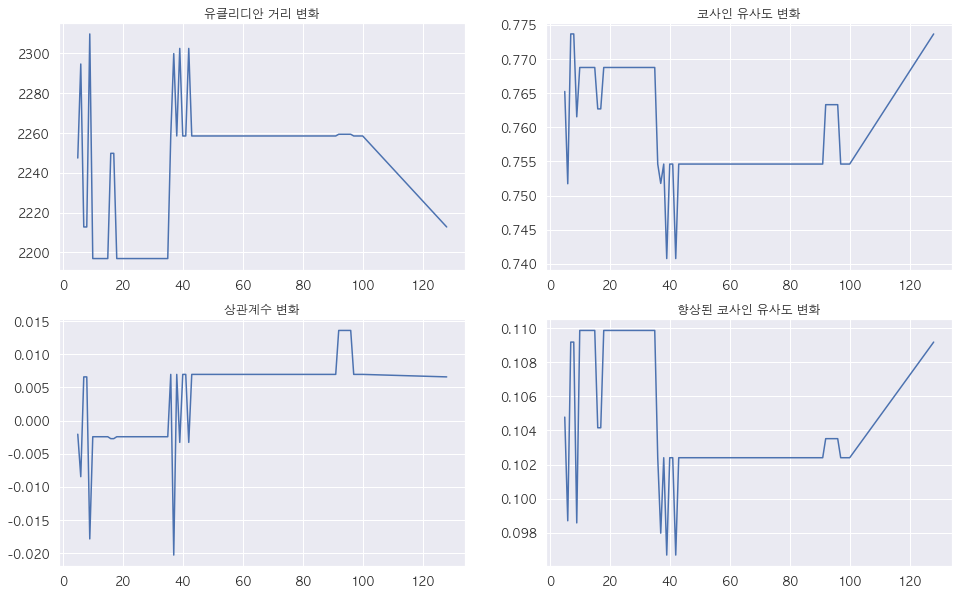

In [159]:
# matplotlib으로 plotting하기
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0][0].plot(info_df['차원축소 사이즈'],info_df['유클리디안 거리'])
axs[0][0].set_title("유클리디안 거리 변화")

axs[0][1].plot(info_df['차원축소 사이즈'],info_df['코사인 유사도'])
axs[0][1].set_title("코사인 유사도 변화")

axs[1][0].plot(info_df['차원축소 사이즈'],info_df['피어슨 상관계수'])
axs[1][0].set_title("상관계수 변화")

axs[1][1].plot(info_df['차원축소 사이즈'],info_df['향상된 코사인 유사도'])
axs[1][1].set_title("향상된 코사인 유사도 변화")

plt.show()

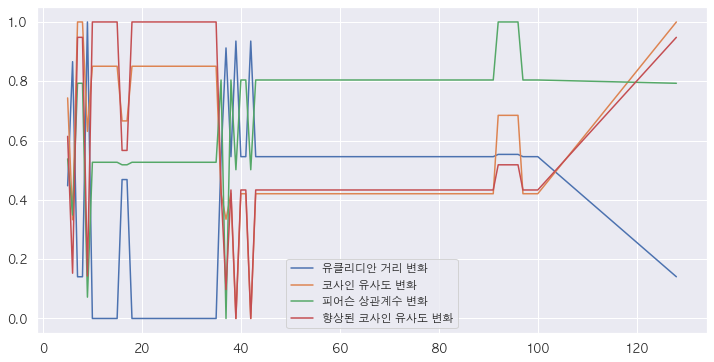

In [160]:
min_max_euc = (info_df['유클리디안 거리'] - info_df['유클리디안 거리'].min()) /\
        (info_df['유클리디안 거리'].max() - info_df['유클리디안 거리'].min())
min_max_cos = (info_df['코사인 유사도'] - info_df['코사인 유사도'].min()) /\
        (info_df['코사인 유사도'].max() - info_df['코사인 유사도'].min())
min_max_corr = (info_df['피어슨 상관계수'] - info_df['피어슨 상관계수'].min()) /\
        (info_df['피어슨 상관계수'].max() - info_df['피어슨 상관계수'].min())
min_max_imp = (info_df['향상된 코사인 유사도'] - info_df['향상된 코사인 유사도'].min()) /\
        (info_df['향상된 코사인 유사도'].max() - info_df['향상된 코사인 유사도'].min())

plt.plot(info_df['차원축소 사이즈'], min_max_euc, label="유클리디안 거리 변화")
plt.plot(info_df['차원축소 사이즈'], min_max_cos, label="코사인 유사도 변화")
plt.plot(info_df['차원축소 사이즈'], min_max_corr, label="피어슨 상관계수 변화")
plt.plot(info_df['차원축소 사이즈'], min_max_imp, label="향상된 코사인 유사도 변화")

plt.legend()

### 위의 단계들에서, 차원축소한 결과가 원본 데이터보다 향상된 코사인 유사도의 평가를 높게 나타날 수도 있다는 것을 확인했다. 그리고 이렇게 추천된 벡터가 거리나, 방향성 면에서 어느정도 조화를 이루고 있는 데이터라는 것을 확인했다. 그러면 이것이 원본 데이터의 차원수에 관련이 있는가에 대해서 확인을 해보자.